In [13]:
import numpy as np
import pandas as pd
import datetime as dt
from mpl_toolkits.axes_grid1 import ImageGrid
from os.path import join, exists , expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss , accuracy_score
from keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from sklearn.linear_model import LogisticRegression
from os import listdir, makedirs
import matplotlib.pyplot as plt
from keras.applications.vgg16 import  preprocess_input, decode_predictions
import cv2
import tensorflow.keras.backend as K

In [3]:
input_size = 224
num_of_class = 16
SEED = 1987
data_dir = 'data/'
labels = pd.read_csv('labels.csv')
sample_sub = pd.read_csv('sample_submission.csv')
#checking length of images and csv's
print(len(listdir('data/train')),len(labels))
print(len(listdir('data/test')),len(sample_sub))

10222 10222
10357 10357


In [4]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(num_of_class).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
y_train = labels_pivot[selected_breed_list].values
ytr = y_train[train_idx]
yv = y_train[valid_idx]
print(labels)

                                     id               breed  target  rank
8      003df8b8a8b05244b1d920bb6cf451f9             basenji       1  55.5
9      0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound       1  63.5
12     00693b8bc2470375cc744a6391d397ec         maltese_dog       1  59.0
29     00bee065dcec471f26394855c5c2f3de               cairn       1  53.5
48     013f8fdf6d638c7bb042f5f17e8a9fdc     tibetan_terrier       1  54.0
...                                 ...                 ...     ...   ...
10207  ffa4e1bf959425bad9228b04af40ac76             basenji       1  55.5
10212  ffc532991d3cd7880d27a449ed1c4770     tibetan_terrier       1  54.0
10215  ffcde16e7da0872c357fbc7e2168c05f            airedale       1  54.0
10216  ffcffab7e4beef9a9b8076ef2ca51909             samoyed       1  55.0
10219  ffe2ca6c940cddfee68fa3cc6c63213f            airedale       1  54.0

[1777 rows x 4 columns]


In [22]:
def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = image.load_img(join(data_dir, train_or_test, img_id + '.jpg'), target_size=size)
    img = image.img_to_array(img)
    img = K.constant(img)
    print(img,'hh')
    return img
#read_img('000bec180eb18c7604dcecc8fe0dba07','train',(224,224))

In [6]:
model = ResNet50(weights='imagenet')




0it [00:00, ?it/s]

tf.Tensor(
[[[153.  91.  40.]
  [182. 127.  73.]
  [172. 123.  67.]
  ...
  [204. 182.  60.]
  [188. 156.  83.]
  [189. 157.  84.]]

 [[189. 136.  94.]
  [142.  95.  51.]
  [148. 108.  59.]
  ...
  [238. 211. 104.]
  [224. 192. 105.]
  [194. 162.  75.]]

 [[111.  70.  38.]
  [ 99.  61.  25.]
  [194. 160. 123.]
  ...
  [229. 194. 110.]
  [227. 192.  88.]
  [212. 177.  73.]]

 ...

 [[186. 119.  66.]
  [183. 116.  63.]
  [189. 123.  71.]
  ...
  [186. 134.  86.]
  [229. 175. 128.]
  [221. 167. 120.]]

 [[186. 119.  66.]
  [184. 117.  64.]
  [190. 124.  72.]
  ...
  [163. 101.  62.]
  [214. 161. 109.]
  [212. 159. 107.]]

 [[181. 114.  61.]
  [186. 119.  66.]
  [191. 125.  73.]
  ...
  [132.  63.  30.]
  [180. 128.  70.]
  [190. 138.  80.]]], shape=(224, 224, 3), dtype=float32) hh
tf.Tensor(
[[[153.  91.  40.]
  [182. 127.  73.]
  [172. 123.  67.]
  ...
  [204. 182.  60.]
  [188. 156.  83.]
  [189. 157.  84.]]

 [[189. 136.  94.]
  [142.  95.  51.]
  [148. 108.  59.]
  ...
  [238. 211. 10

ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (224, 224, 3)

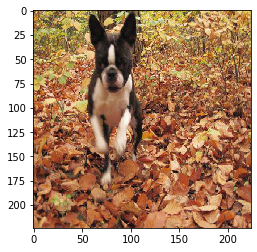

In [23]:
for i, (img_id,breed) in tqdm(enumerate(labels[['id','breed']].values)):
    img = read_img('000bec180eb18c7604dcecc8fe0dba07', 'train', (224, 224))
#     img = image.array_to_img(img)
    plt.imshow(image.array_to_img(img))
    print(img)
#     x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = model.predict(img)
    _, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
    plt.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name , prob), color='w', backgroundcolor='k', alpha=0.8)
    plt.text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    plt.axis('off')
    plt.show()